# Data Pre-Processing
<br>
This notebook is used to load, explore and process the raw data into a RL dataset for the environment.

In [1]:
#Import libraries

import pandas as pd
import pandas_market_calendars as mcal
import ta
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

## Load the Raw data
<br>
The raw data purchased comes in two separate csvs that need to be loaded and merged.

In [2]:
#Read Raw Data for ECL: Ecolab Inc

file1 = 'Raw Data/ECL_2000_2009.csv'
header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
df1 = pd.read_csv(file1, names=header, parse_dates = ['Timestamp'], infer_datetime_format=True)
print (df1.dtypes)
df1.head(5)

Timestamp    datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
dtype: object


,Timestamp,Open,High,Low,Close,Volume
0,2000-01-03 09:32:00,19.500,19.500,19.500,19.500,24200
1,2000-01-03 09:33:00,19.500,19.500,19.500,19.500,400
2,2000-01-03 09:34:00,19.500,19.500,19.500,19.500,200
3,2000-01-03 09:36:00,19.500,19.500,19.500,19.500,400
4,2000-01-03 09:39:00,19.438,19.438,19.438,19.438,200


In [3]:
#Read Second File

file2 = 'Raw Data/ECL_2010_2019.csv'
header = ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']
df2 = pd.read_csv(file2, names=header, parse_dates = ['Timestamp'], infer_datetime_format=True)
print (df2.dtypes)
df2.head(5)

Timestamp    datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
dtype: object


,Timestamp,Open,High,Low,Close,Volume
0,2010-01-04 09:30:00,45.03,45.03,44.99,44.99,493
1,2010-01-04 09:31:00,45.08,45.08,45.08,45.08,100
2,2010-01-04 09:32:00,45.02,45.21,45.02,45.13,5400
3,2010-01-04 09:33:00,45.09,45.17,44.86,45.00,9186
4,2010-01-04 09:34:00,45.07,45.09,45.04,45.09,800


In [4]:
# Concatenate DataFrames

df3 = pd.concat([df1,df2])
print (df3.dtypes)
print ('\n There are: '+str(len(df3))+' datapoints in the concatenated dataframe.')
df3.head(5)

Timestamp    datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume                int64
dtype: object

 There are: 1778998 datapoints in the concatenated dataframe.


,Timestamp,Open,High,Low,Close,Volume
0,2000-01-03 09:32:00,19.500,19.500,19.500,19.500,24200
1,2000-01-03 09:33:00,19.500,19.500,19.500,19.500,400
2,2000-01-03 09:34:00,19.500,19.500,19.500,19.500,200
3,2000-01-03 09:36:00,19.500,19.500,19.500,19.500,400
4,2000-01-03 09:39:00,19.438,19.438,19.438,19.438,200


In [5]:
# Need to localize the timezone for the timestamps to New York (obvious why below)

df3.Timestamp = df3.Timestamp.dt.tz_localize('America/New_York')
df3.head(5)

,Timestamp,Open,High,Low,Close,Volume
0,2000-01-03 09:32:00-05:00,19.500,19.500,19.500,19.500,24200
1,2000-01-03 09:33:00-05:00,19.500,19.500,19.500,19.500,400
2,2000-01-03 09:34:00-05:00,19.500,19.500,19.500,19.500,200
3,2000-01-03 09:36:00-05:00,19.500,19.500,19.500,19.500,400
4,2000-01-03 09:39:00-05:00,19.438,19.438,19.438,19.438,200


In [6]:
df3.describe()

,Open,High,Low,Close,Volume
count,1.778998e+06,1.778998e+06,1.778998e+06,1.778998e+06,1.778998e+06
mean,7.144119e+01,7.144763e+01,7.142357e+01,7.144112e+01,3.102394e+03
std,4.759463e+01,4.760176e+01,4.758571e+01,4.759430e+01,7.344557e+03
min,7.063000e+00,0.000000e+00,7.063000e+00,7.079000e+00,1.000000e+00
25%,3.447000e+01,3.447000e+01,3.445000e+01,3.447000e+01,7.000000e+02
50%,4.897000e+01,4.899000e+01,4.896000e+01,4.897000e+01,1.564000e+03
75%,1.124300e+02,1.124500e+02,1.124100e+02,1.124300e+02,3.300000e+03
max,2.817600e+02,2.817600e+02,2.817600e+02,2.817600e+02,2.749482e+06


## Explore the data
<br>
Plotting the data in order to look for any odd things that need to be processed out.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x125069940>,
      dtype=object)

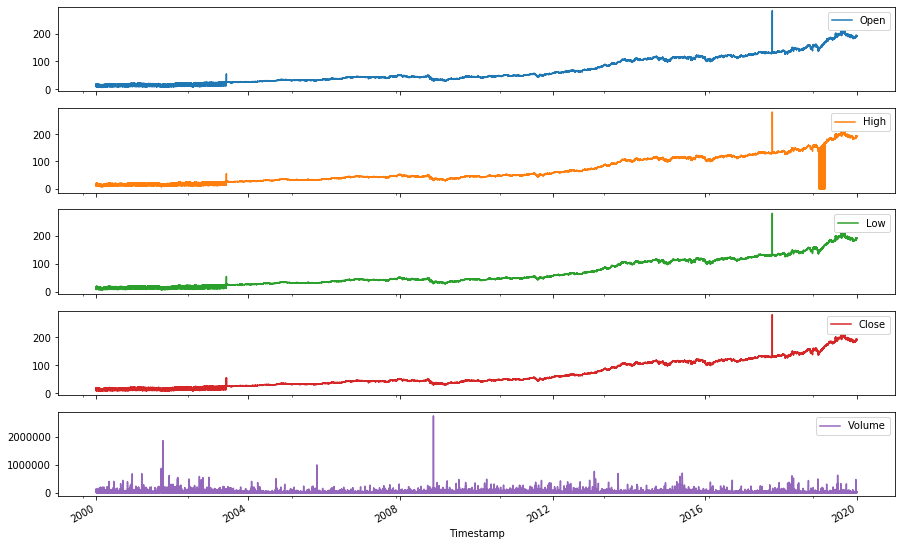

In [7]:
df3.plot(x='Timestamp', y=['Open', 'High', 'Low', 'Close', 'Volume'], subplots=True, figsize=(15,10))

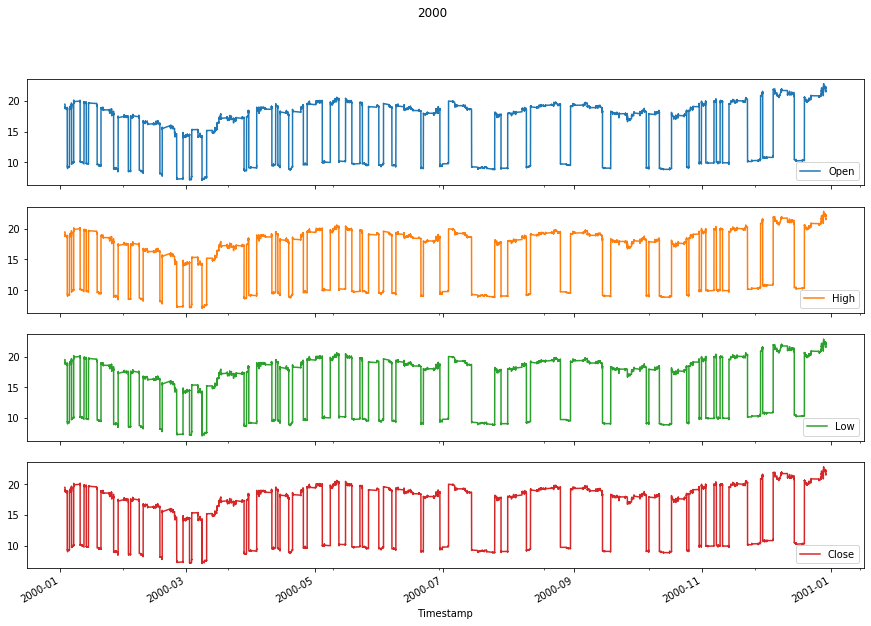

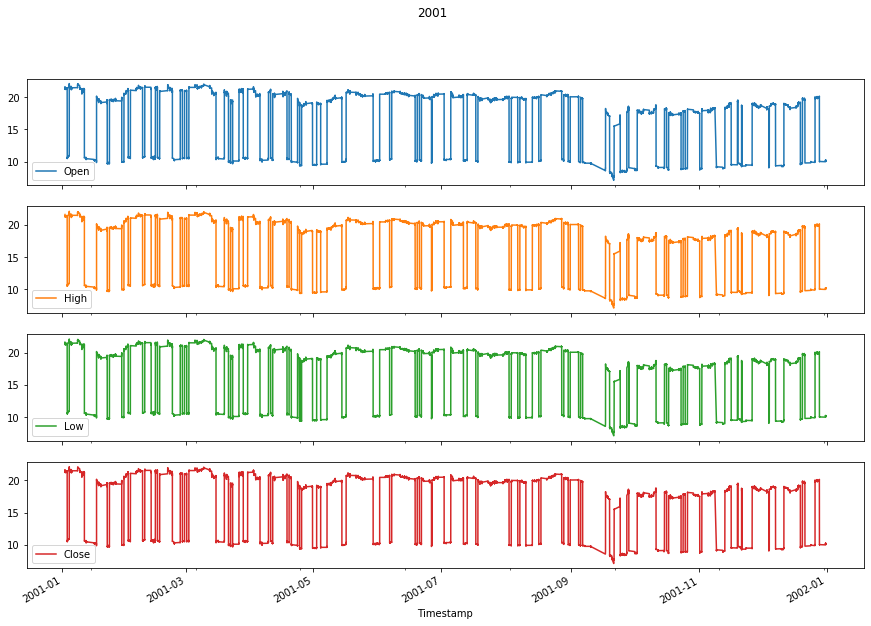

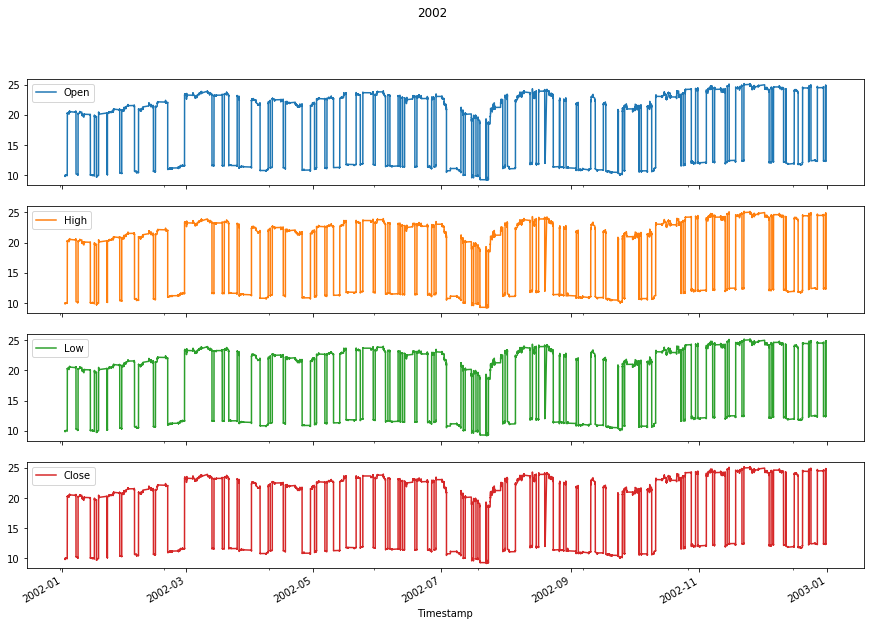

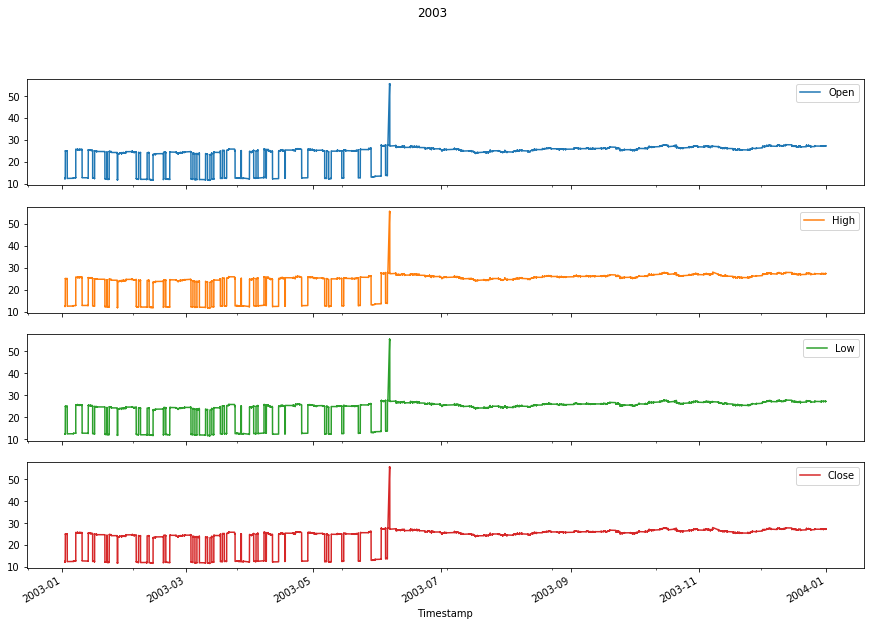

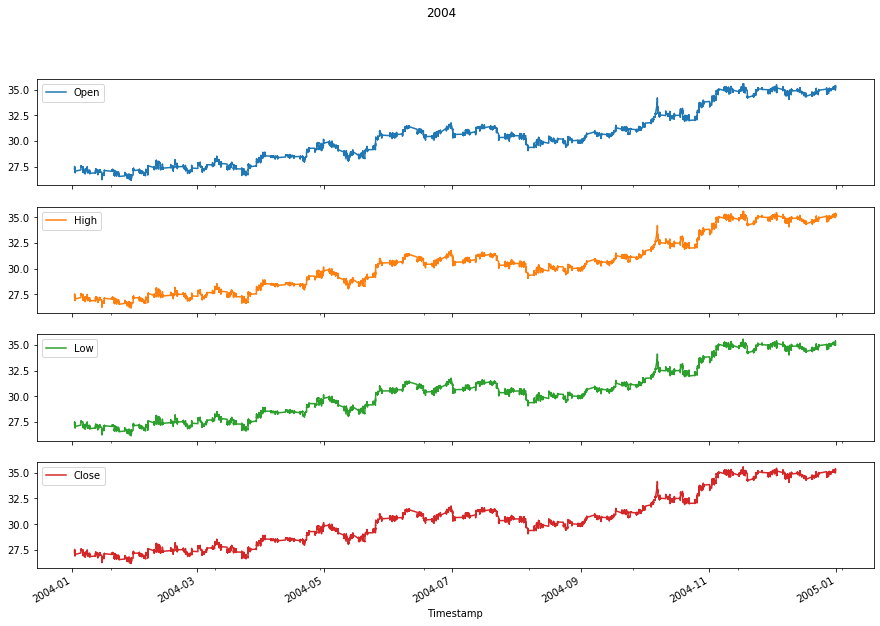

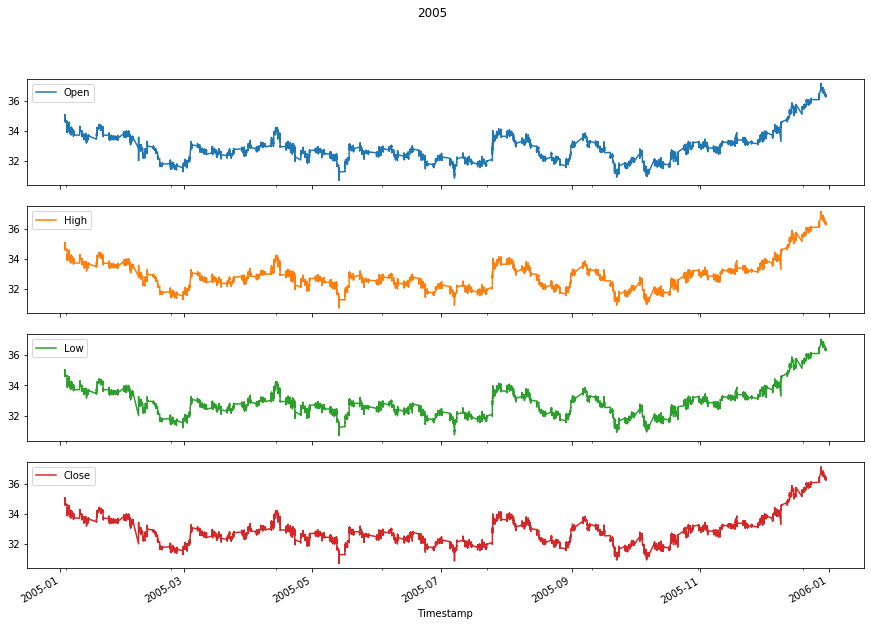

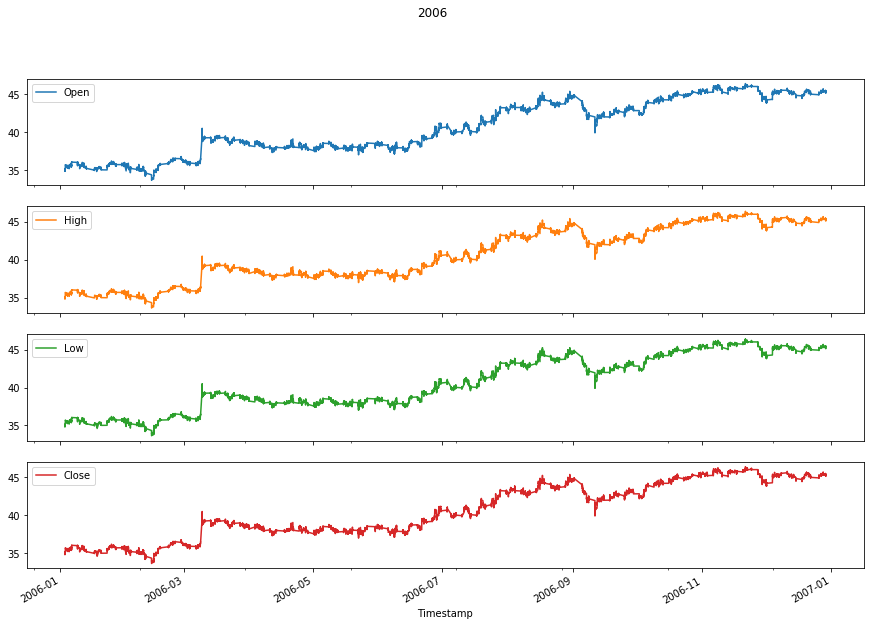

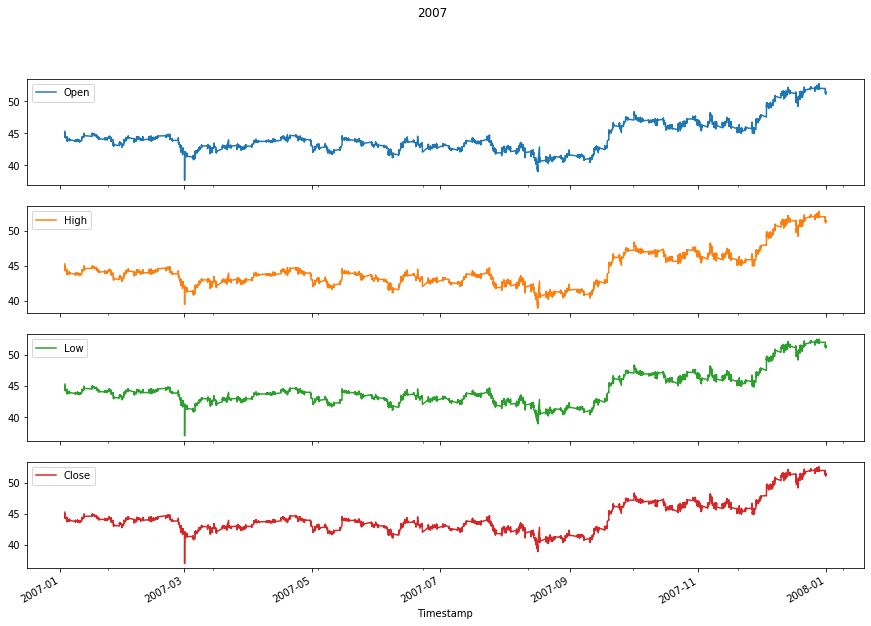

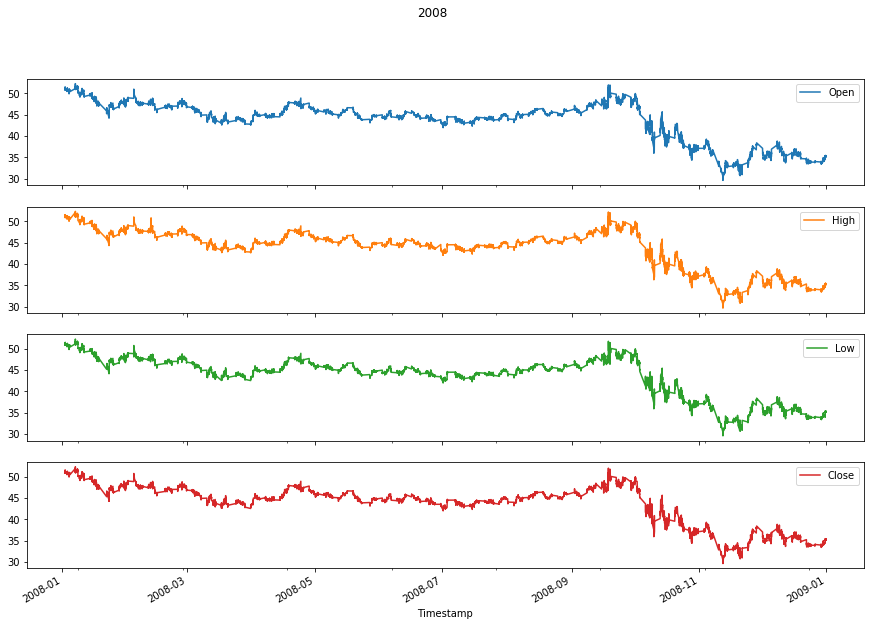

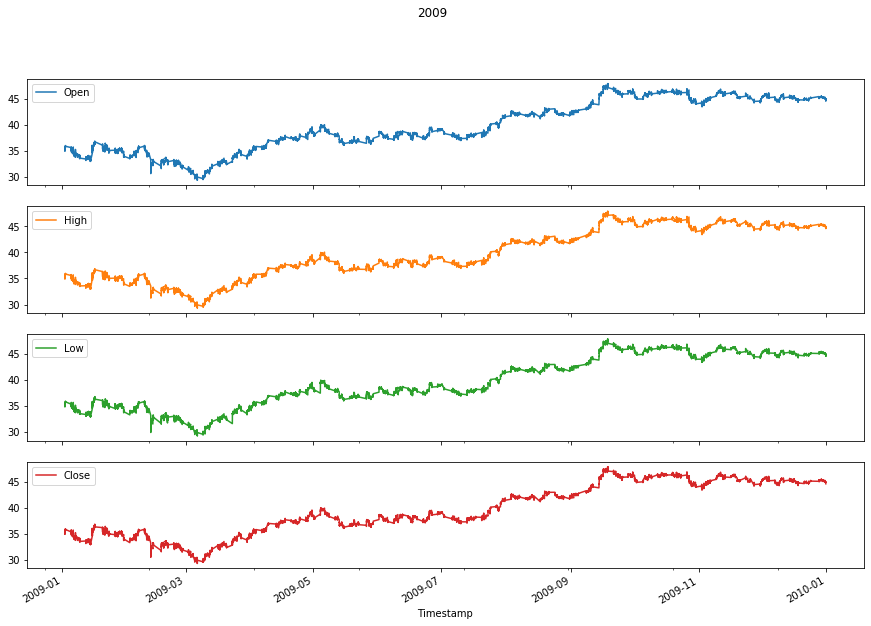

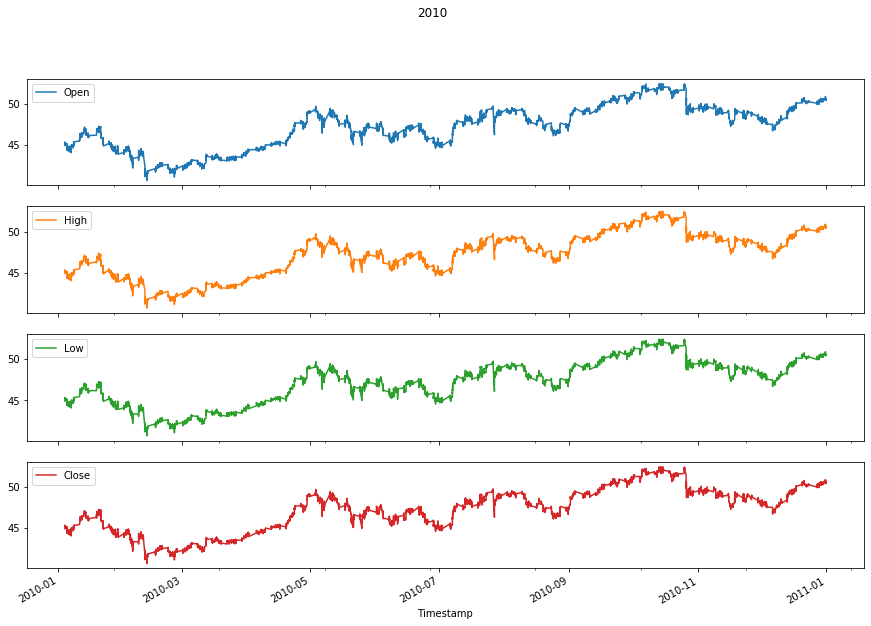

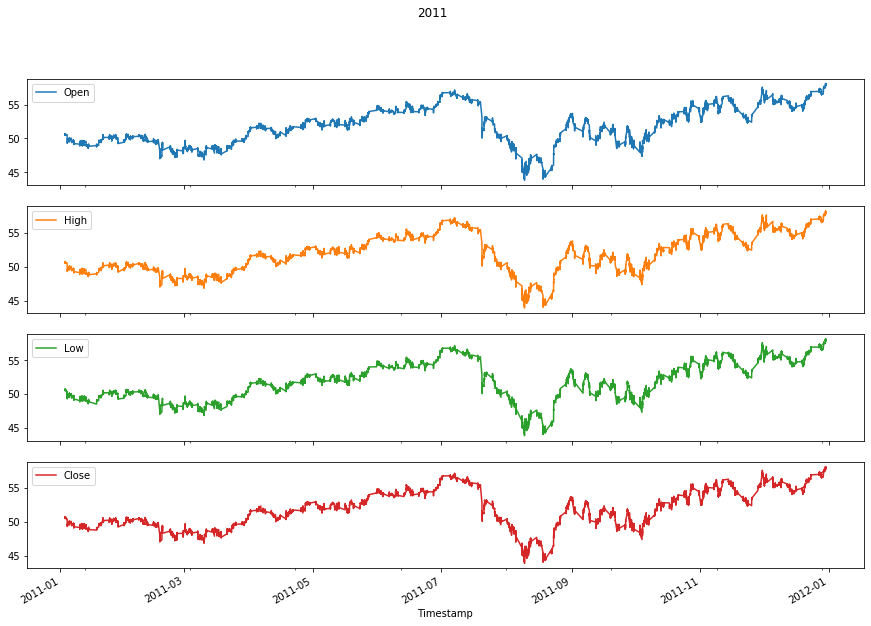

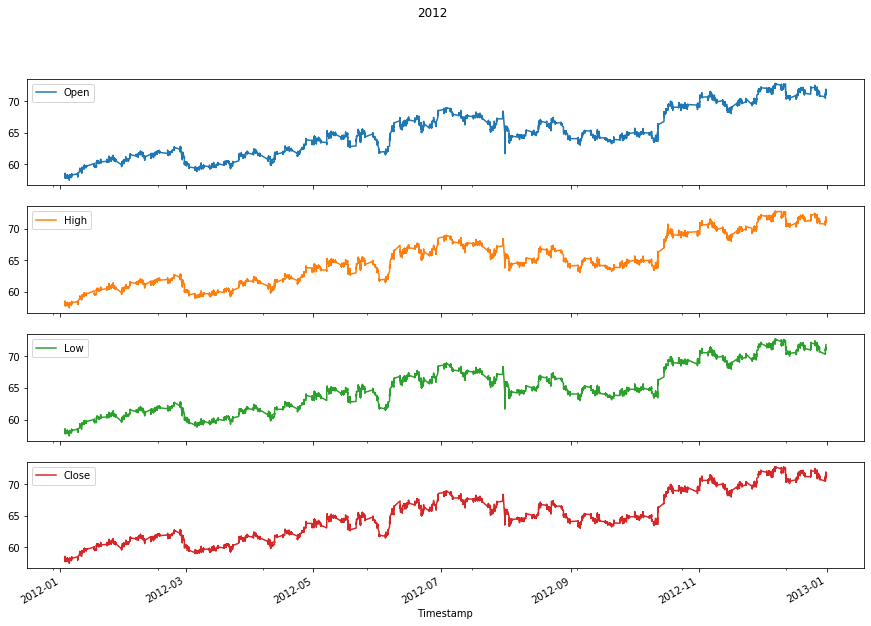

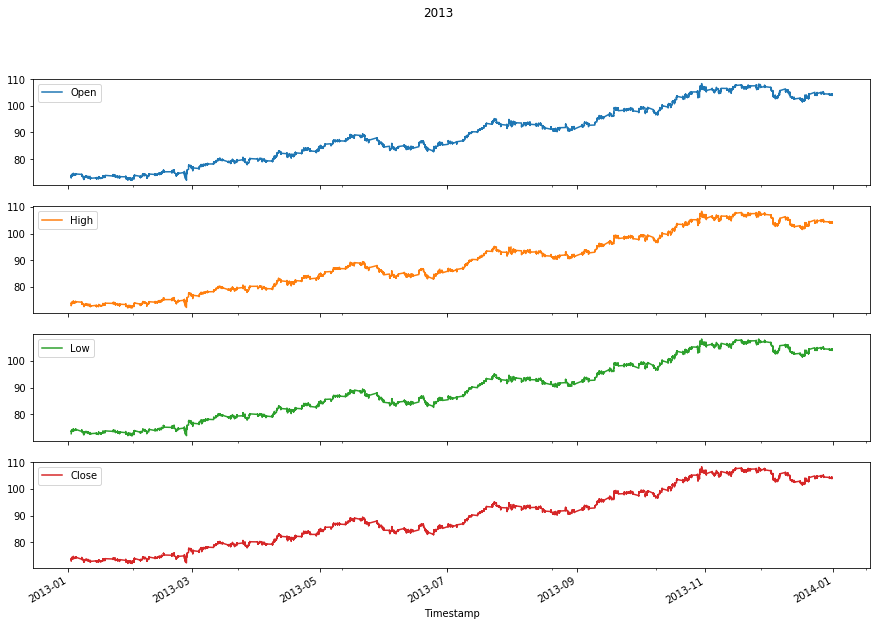

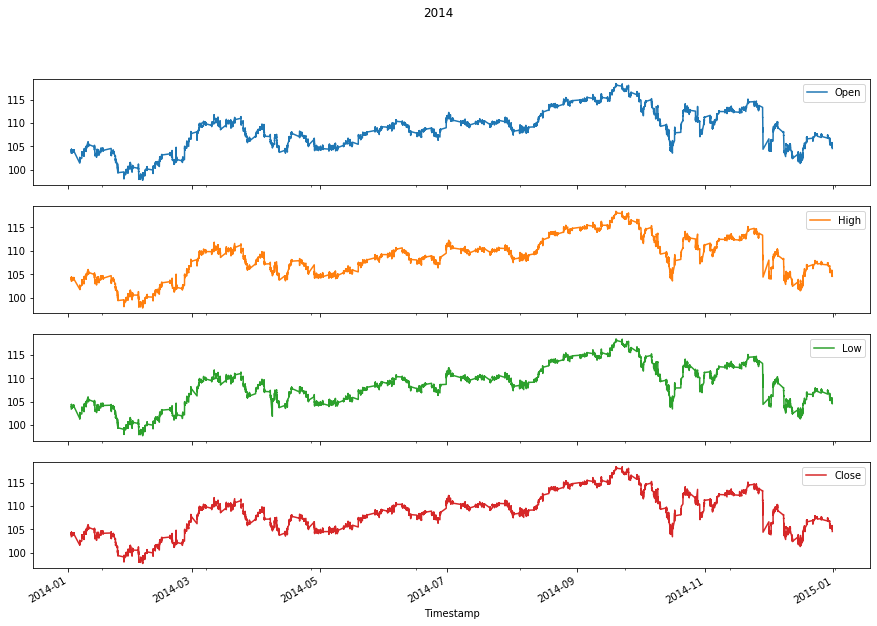

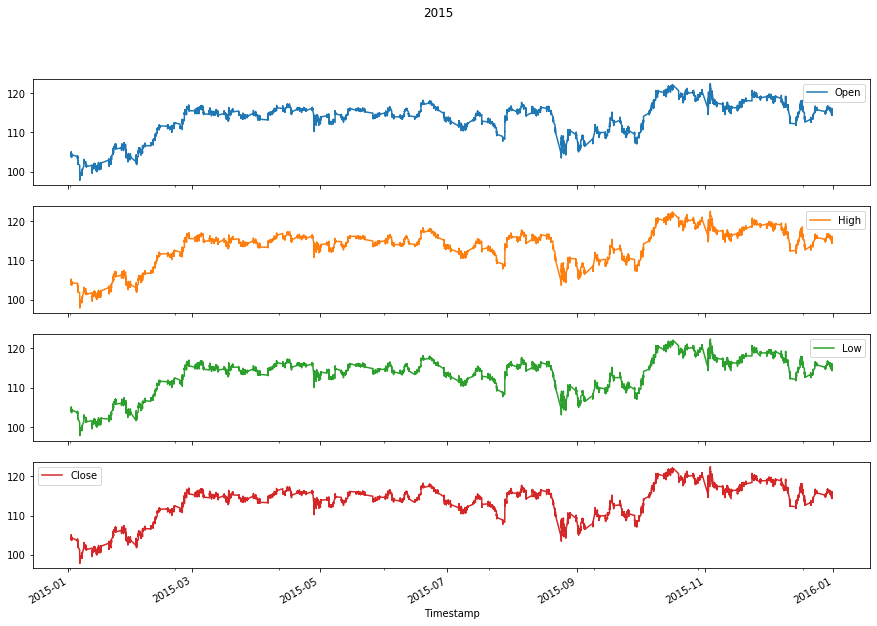

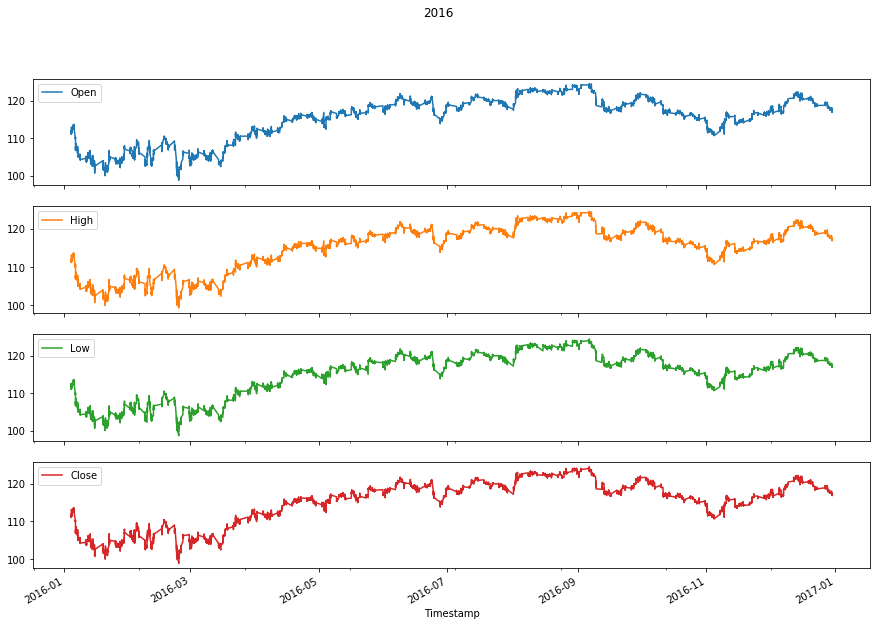

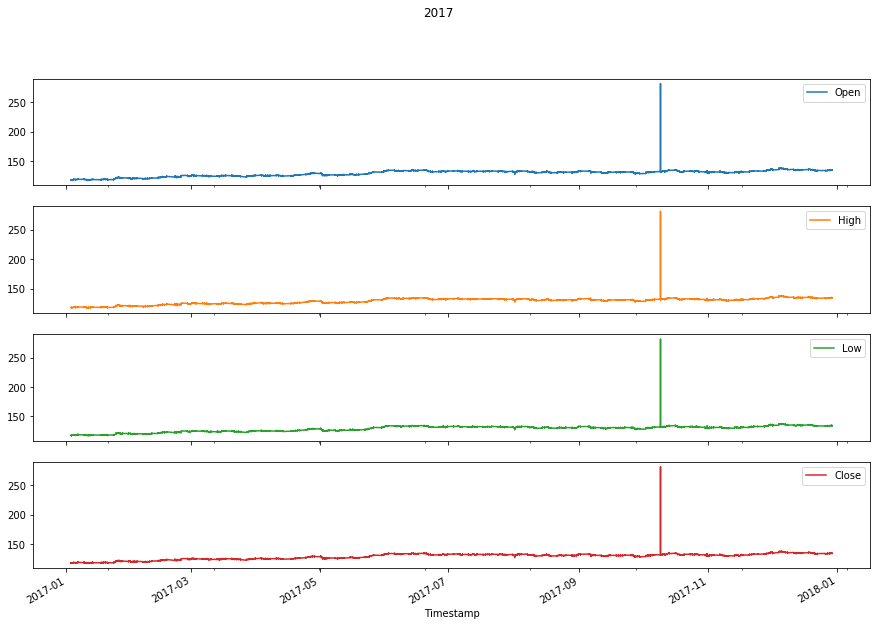

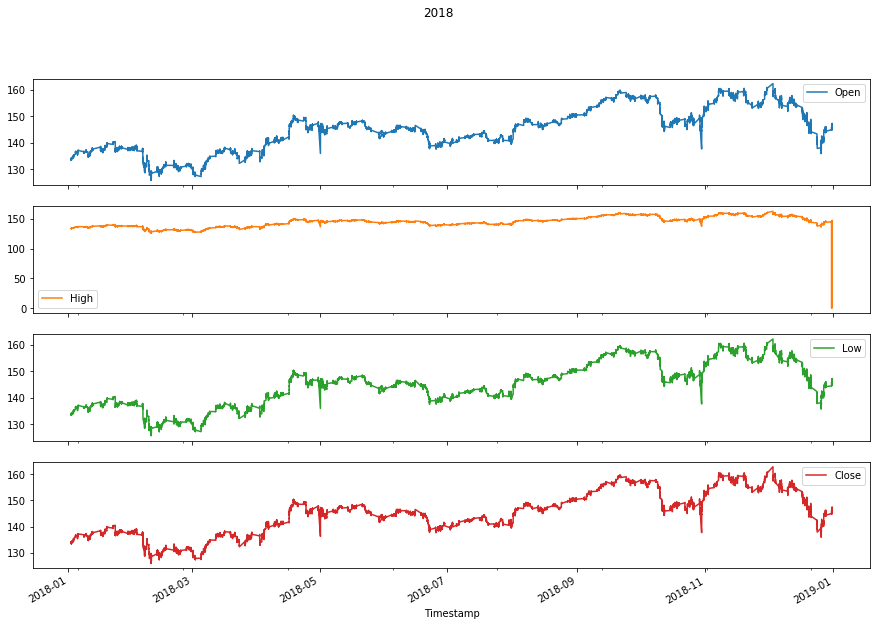

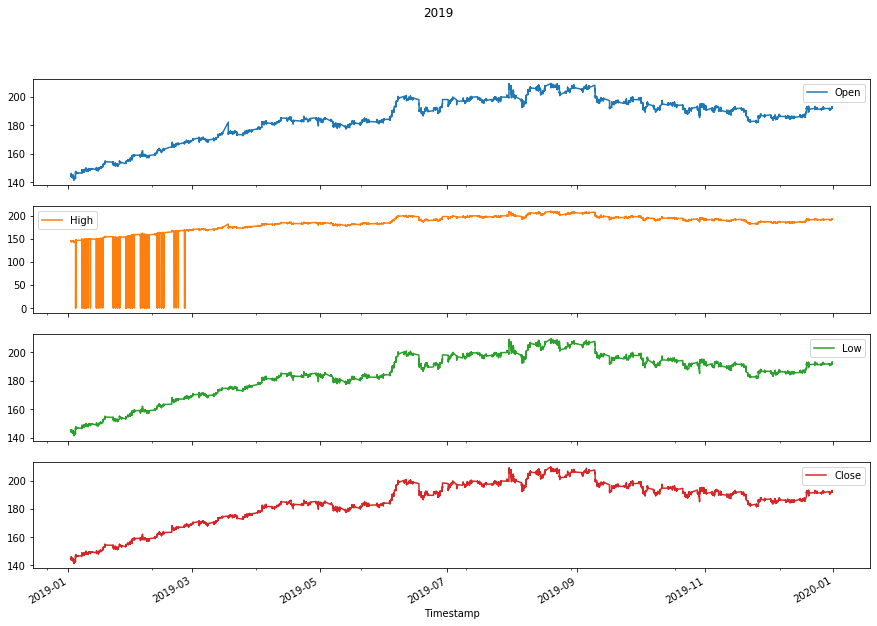

In [8]:
for i in np.arange(2000, 2020, 1):
    df = df3[(df3.Timestamp < str(i+1)+'-01-01') & (df3.Timestamp >= str(i)+'-01-01')]
    df.plot(x='Timestamp',
            y=['Open', 'High', 'Low', 'Close'],
            subplots=True, 
            title=i,
            figsize=(15,10))

### Observations
* Price is unstable until ~2003
* High Price is lower than Low Price during 2019
* One odd trading day in 2017
* Key observation that was expected when purchasing the data. All timestamps that have zero volume have been removed from the dataset. As above in `df3.head(5)`: 09:31 & 09:35 are missing.

## Data Wrangling
### 1. Missing timestamps
I need to fill in all missing timestamps in the dataset. I'll do this using a merge_asf to just copy the nearest row across. Later I'll set the volume to zero for those timestamps.
In order to do this, I've:
* Created a market calendar for the period in question
* Turned that market calendar into a datetimeindex for an empty dataframe
* Used merge_asof to merge and fill the data from df3 above
* Set all "filled" timestamps Volume = 0

In [9]:
# Create the NYSE market calendar using the pandas_market_calendars library

#https://pypi.org/project/pandas-market-calendars/
#https://pandas-market-calendars.readthedocs.io/en/latest/usage.html#setup-new-exchange-calendar

nyse = mcal.get_calendar('NYSE')
start = '2000-01-01'
end = '2019-12-31'
early = nyse.schedule(start_date=start, end_date=end)
ts = mcal.date_range(early, frequency='1min').tz_convert('America/New_York')

In [10]:
# Create an empty dataframe from the datetimeindex above

empty = ts.to_frame()
#empty['Open'], empty['High'], empty['Low'], empty['Close'], empty['Volume'] = 0.0,0.0,0.0,0.0,0
empty.rename(columns={0:'Timestamp'}, inplace=True)
print (empty.dtypes)
empty.head(5)

Timestamp    datetime64[ns, America/New_York]
dtype: object


,Timestamp
2000-01-03 09:31:00-05:00,2000-01-03 09:31:00-05:00
2000-01-03 09:32:00-05:00,2000-01-03 09:32:00-05:00
2000-01-03 09:33:00-05:00,2000-01-03 09:33:00-05:00
2000-01-03 09:34:00-05:00,2000-01-03 09:34:00-05:00
2000-01-03 09:35:00-05:00,2000-01-03 09:35:00-05:00


In [11]:
# Merge_asof the two dataframes to fill in all timestamps

#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.merge_asof.html

full = pd.merge_asof(empty, df3, on='Timestamp', direction='nearest')
print ('Length of full dataframe: '+str(len(full)))
print ('Length of the original dataframe: '+str(len(df3)))
full.head(10)

Length of full dataframe: 1953810
Length of the original dataframe: 1778998


,Timestamp,Open,High,Low,Close,Volume
0,2000-01-03 09:31:00-05:00,19.500,19.500,19.500,19.500,24200
1,2000-01-03 09:32:00-05:00,19.500,19.500,19.500,19.500,24200
2,2000-01-03 09:33:00-05:00,19.500,19.500,19.500,19.500,400
3,2000-01-03 09:34:00-05:00,19.500,19.500,19.500,19.500,200
4,2000-01-03 09:35:00-05:00,19.500,19.500,19.500,19.500,200
5,2000-01-03 09:36:00-05:00,19.500,19.500,19.500,19.500,400
6,2000-01-03 09:37:00-05:00,19.500,19.500,19.500,19.500,400
7,2000-01-03 09:38:00-05:00,19.438,19.438,19.438,19.438,200
8,2000-01-03 09:39:00-05:00,19.438,19.438,19.438,19.438,200
9,2000-01-03 09:40:00-05:00,19.500,19.500,19.500,19.500,2000


In [12]:
# Plot the new dataframe with all the timestamps filled in

if False:
    full.plot(x='Timestamp', y=['Open', 'High', 'Low', 'Close', 'Volume'], subplots=True, figsize=(15,10))

In [13]:
# Create a list of all the timestamps in df3 (raw data)

tss = df3.Timestamp.to_numpy()

In [14]:
# Set all 'filled' Volume timestamps to 0

#%%timeit

full['New_Volume'] = np.where(full['Timestamp'].isin(tss),full['Volume'], 0)

# https://stackoverflow.com/questions/60254392/turbocharge-a-lambda-function-comparing-values-in-two-dataframes

In [15]:
full.head(10)

,Timestamp,Open,High,Low,Close,Volume,New_Volume
0,2000-01-03 09:31:00-05:00,19.500,19.500,19.500,19.500,24200,0
1,2000-01-03 09:32:00-05:00,19.500,19.500,19.500,19.500,24200,24200
2,2000-01-03 09:33:00-05:00,19.500,19.500,19.500,19.500,400,400
3,2000-01-03 09:34:00-05:00,19.500,19.500,19.500,19.500,200,200
4,2000-01-03 09:35:00-05:00,19.500,19.500,19.500,19.500,200,0
5,2000-01-03 09:36:00-05:00,19.500,19.500,19.500,19.500,400,400
6,2000-01-03 09:37:00-05:00,19.500,19.500,19.500,19.500,400,0
7,2000-01-03 09:38:00-05:00,19.438,19.438,19.438,19.438,200,0
8,2000-01-03 09:39:00-05:00,19.438,19.438,19.438,19.438,200,200
9,2000-01-03 09:40:00-05:00,19.500,19.500,19.500,19.500,2000,2000


In [16]:
full.tail(10)

,Timestamp,Open,High,Low,Close,Volume,New_Volume
1953800,2019-12-31 15:51:00-05:00,192.70,192.71,192.65,192.67,3800,3800
1953801,2019-12-31 15:52:00-05:00,192.67,192.80,192.67,192.80,3100,3100
1953802,2019-12-31 15:53:00-05:00,192.80,192.91,192.80,192.85,3000,3000
1953803,2019-12-31 15:54:00-05:00,192.84,192.93,192.79,192.86,2500,2500
1953804,2019-12-31 15:55:00-05:00,192.83,192.91,192.80,192.91,8100,8100
1953805,2019-12-31 15:56:00-05:00,192.93,192.96,192.89,192.89,4600,4600
1953806,2019-12-31 15:57:00-05:00,192.89,192.89,192.76,192.78,6000,6000
1953807,2019-12-31 15:58:00-05:00,192.80,192.86,192.76,192.86,9100,9100
1953808,2019-12-31 15:59:00-05:00,192.88,193.12,192.88,192.96,17900,17900
1953809,2019-12-31 16:00:00-05:00,192.88,193.12,192.88,192.96,17900,0


Yay! That's what I was after :-)

In [17]:
full.groupby('New_Volume').size()

New_Volume
0          178688
1             469
2             383
3             318
4             272
            ...  
762609          1
869128          1
992900          1
1861200         1
2749482         1
Length: 32598, dtype: int64

### 2. High price lower than low price for timestamp

In [18]:
# Function to fix High Price being lower than Low price, apply to 'full' dataframe

tqdm.pandas()
full['High_Adj'] = full.progress_apply(lambda x: x['High'] if x['High'] >= x['Low'] else x['Low'], axis=1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x16e806f98>,
      dtype=object)

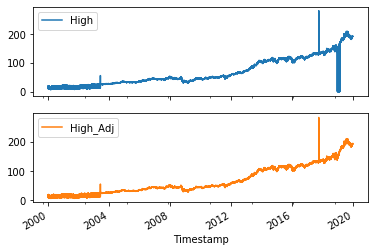

In [19]:
# Plot the adjusted and raw High Price to check function above works

full.plot(x='Timestamp', y=['High', 'High_Adj'], subplots=True)

### 3. Screwy Day in 2017

In [20]:
# Using the site below, I can see that this candle is wrong. I'm just going to copy over it
#https://www.marketwatch.com/investing/stock/ECL/historical?siteid=mktw&date=&x=11&y=15

#09/10/2017 10:22

full[(full.Timestamp > '2017-10-09 10:20') & (full.Timestamp < '2017-10-09 10:25')]

,Timestamp,Open,High,Low,Close,Volume,New_Volume,High_Adj
1736330,2017-10-09 10:21:00-04:00,131.715,131.72,131.715,131.72,205,205,131.72
1736331,2017-10-09 10:22:00-04:00,281.760,281.76,281.760,281.76,55,55,281.76
1736332,2017-10-09 10:23:00-04:00,131.690,131.72,131.690,131.72,600,600,131.72
1736333,2017-10-09 10:24:00-04:00,181.760,181.76,181.760,181.76,18,18,181.76


In [21]:
index = 1736331

full.loc[index,'Open'] = (full.Open[index-1] + full.Open[index+1]) / 2
full.loc[index,'High_Adj'] = (full.High_Adj[index-1] + full.High_Adj[index+1]) / 2
full.loc[index,'Low'] = (full.Low[index-1] + full.Low[index+1]) / 2
full.loc[index,'Close'] = (full.Close[index-1] + full.Close[index+1]) / 2
full.loc[index,'New_Volume'] = 0 #Unsure of price so I'll set volume to zero so this agent can't trade this timestamp
# ignoring High and Volume columns as I'm about to delete them
full.loc[index]

Timestamp     2017-10-09 10:22:00-04:00
Open                            131.702
High                             281.76
Low                             131.702
Close                            131.72
Volume                               55
New_Volume                            0
High_Adj                         131.72
Name: 1736331, dtype: object

In [22]:
full[(full.Timestamp > '2017-10-09 10:20') & (full.Timestamp < '2017-10-09 10:25')]

,Timestamp,Open,High,Low,Close,Volume,New_Volume,High_Adj
1736330,2017-10-09 10:21:00-04:00,131.7150,131.72,131.7150,131.72,205,205,131.72
1736331,2017-10-09 10:22:00-04:00,131.7025,281.76,131.7025,131.72,55,0,131.72
1736332,2017-10-09 10:23:00-04:00,131.6900,131.72,131.6900,131.72,600,600,131.72
1736333,2017-10-09 10:24:00-04:00,181.7600,181.76,181.7600,181.76,18,18,181.76


array([<matplotlib.axes._subplots.AxesSubplot object at 0x167952f60>],
      dtype=object)

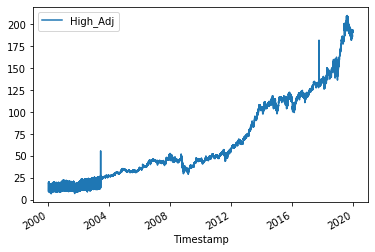

In [23]:
full.plot(x='Timestamp', y=['High_Adj'], subplots=True)

In [24]:
#I can now see another off candle that doesn't check out at index 1736333

index = 1736333

full.loc[index,'Open'] = (full.Open[index-1] + full.Open[index+1]) / 2
full.loc[index,'High_Adj'] = (full.High_Adj[index-1] + full.High_Adj[index+1]) / 2
full.loc[index,'Low'] = (full.Low[index-1] + full.Low[index+1]) / 2
full.loc[index,'Close'] = (full.Close[index-1] + full.Close[index+1]) / 2
full.loc[index,'New_Volume'] = 0 #Unsure of price so I'll set volume to zero so this agent can't trade this timestamp
# ignoring High and Volume columns as I'm about to delete them
full.loc[index]

Timestamp     2017-10-09 10:24:00-04:00
Open                            131.675
High                             181.76
Low                             131.675
Close                            131.69
Volume                               18
New_Volume                            0
High_Adj                         131.69
Name: 1736333, dtype: object

array([<matplotlib.axes._subplots.AxesSubplot object at 0x16d95c898>],
      dtype=object)

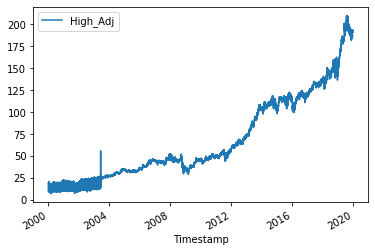

In [25]:
full.plot(x='Timestamp', y=['High_Adj'], subplots=True)

### 4. Unstable price until 2003ish

In [26]:
# Will ignore this as I'm only going to use 2005 onwards

### Remove unnecessary columns

In [27]:
# Remove High and Volume
if True:
    full.drop(columns=['High', 'Volume'], inplace=True)

# Rename New_Volume and High_Adj
if True:
    full.rename(columns={'New_Volume' : 'Volume', 'High_Adj' : 'High'}, inplace=True)

#Rearrange Col order
full = full[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']]

#Check results
full.head(5)

,Timestamp,Open,High,Low,Close,Volume
0,2000-01-03 09:31:00-05:00,19.5,19.5,19.5,19.5,0
1,2000-01-03 09:32:00-05:00,19.5,19.5,19.5,19.5,24200
2,2000-01-03 09:33:00-05:00,19.5,19.5,19.5,19.5,400
3,2000-01-03 09:34:00-05:00,19.5,19.5,19.5,19.5,200
4,2000-01-03 09:35:00-05:00,19.5,19.5,19.5,19.5,0


## Create the hour and day datasets

In [28]:
#http://benalexkeen.com/resampling-time-series-data-with-pandas/

source = full.copy()
source.set_index('Timestamp', inplace=True)
source.head(5)

,Open,High,Low,Close,Volume
Timestamp,,,,,
2000-01-03 09:31:00-05:00,19.5,19.5,19.5,19.5,0
2000-01-03 09:32:00-05:00,19.5,19.5,19.5,19.5,24200
2000-01-03 09:33:00-05:00,19.5,19.5,19.5,19.5,400
2000-01-03 09:34:00-05:00,19.5,19.5,19.5,19.5,200
2000-01-03 09:35:00-05:00,19.5,19.5,19.5,19.5,0


In [29]:
day = pd.DataFrame()
day['Open'] = source.Open.resample('D').first()
day['High'] = source.High.resample('D').max()
day['Low'] = source.Low.resample('D').min()
day['Close'] = source.Close.resample('D').last()
day['Volume'] = source.Volume.resample('D').sum()
#day.head(50)
print ('There are',len(day),'calendar days in the dataset.')

There are 7303 calendar days in the dataset.


In [30]:
#Need to drop all rows with NaN as it has added all the non-trading days back in with NaNs

day.dropna(inplace=True)
day.reset_index(inplace=True)
print ('There are',len(day),'trading days in the dataset.')
day.head(10)

There are 5031 trading days in the dataset.


,Timestamp,Open,High,Low,Close,Volume
0,2000-01-03 00:00:00-05:00,19.500,19.500,18.750,18.813,580000
1,2000-01-04 00:00:00-05:00,18.813,18.969,9.000,9.188,1528798
2,2000-01-05 00:00:00-05:00,9.250,19.188,9.188,19.063,700200
3,2000-01-06 00:00:00-05:00,18.750,19.688,9.703,9.953,1274204
4,2000-01-07 00:00:00-05:00,9.953,20.156,9.906,19.906,1326200
5,2000-01-10 00:00:00-05:00,20.000,20.188,10.045,10.140,1181916
6,2000-01-11 00:00:00-05:00,10.095,10.110,9.970,10.045,1034400
7,2000-01-12 00:00:00-05:00,9.750,19.906,9.750,19.719,849198
8,2000-01-13 00:00:00-05:00,19.719,19.875,9.766,9.782,882996
9,2000-01-14 00:00:00-05:00,9.750,19.750,9.719,19.688,642000


In [31]:
#Same procedure for hours

hour = pd.DataFrame()
hour['Open'] = source.Open.resample('H').first()
hour['High'] = source.High.resample('H').max()
hour['Low'] = source.Low.resample('H').min()
hour['Close'] = source.Close.resample('H').last()
hour['Volume'] = source.Volume.resample('H').sum()
#hour.head(50)
print ('There are',len(hour),'hours in the dataset.')

There are 175256 hours in the dataset.


In [32]:
#Need to drop all rows with NaN as it has added all the non-trading days back in with NaNs

hour.dropna(inplace=True)
hour.reset_index(inplace=True)
print ('There are',len(hour),'hours in the dataset.')
hour.head(10)

There are 40110 hours in the dataset.


,Timestamp,Open,High,Low,Close,Volume
0,2000-01-03 09:00:00-05:00,19.500,19.500,19.344,19.438,81000
1,2000-01-03 10:00:00-05:00,19.469,19.500,19.188,19.219,77000
2,2000-01-03 11:00:00-05:00,19.188,19.188,18.969,19.000,117800
3,2000-01-03 12:00:00-05:00,19.031,19.031,18.750,18.969,79600
4,2000-01-03 13:00:00-05:00,18.906,19.000,18.781,18.813,58400
5,2000-01-03 14:00:00-05:00,18.813,18.906,18.813,18.875,68400
6,2000-01-03 15:00:00-05:00,18.906,18.938,18.750,18.813,97400
7,2000-01-03 16:00:00-05:00,18.813,18.813,18.813,18.813,400
8,2000-01-04 09:00:00-05:00,18.813,18.969,18.563,18.969,82800
9,2000-01-04 10:00:00-05:00,18.969,18.969,9.375,9.391,116400


## Add the Technical Indicators using the TA library
Some clever folks have published this library which can easily add technical indicators to OHLCV datasets. This is exactly what we need for this job. As per the Proposal, I'll add the following:
* SMA
* EMA
* RSI
* ROC
* MACD
* WO
* ATR

NEED TO ADD A VOLUME BASED INDICATOR HERE....

### Simple Moving Average

In [33]:
#Rolling Mean of Close Price

full['SMA_10'] = full['Close'].rolling(10*60*8).mean()
full['SMA_50'] = full['Close'].rolling(50*60*8).mean()
#full.head(75)

day['SMA_10'] = day['Close'].rolling(10).mean()
day['SMA_50'] = day['Close'].rolling(50).mean()
#day.head(75)

hour['SMA_10'] = hour['Close'].rolling(10*8).mean()
hour['SMA_50'] = hour['Close'].rolling(50*8).mean()
#hour.head(75)

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


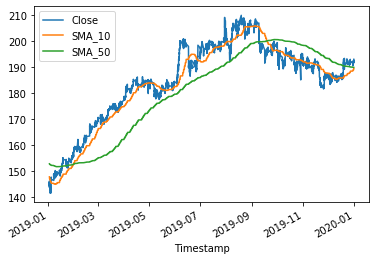

In [34]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'SMA_10', 'SMA_50'])

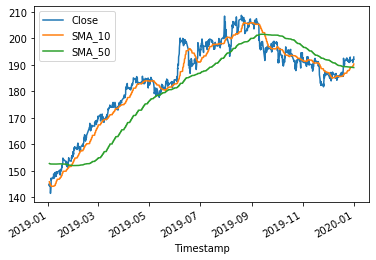

In [35]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'SMA_10', 'SMA_50'])

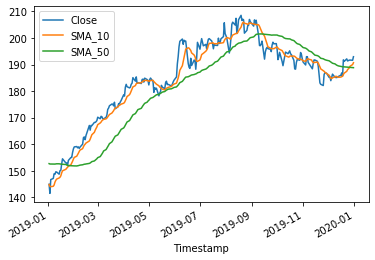

In [36]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'SMA_10', 'SMA_50'])

### Exponential Moving Average

In [37]:
full['EMA_10'] = ta.trend.ema_indicator(full['Close'], n=10*60*8, fillna=False)
full['EMA_50'] = ta.trend.ema_indicator(full['Close'], n=50*60*8, fillna=False)
#full.head(20)

hour['EMA_10'] = ta.trend.ema_indicator(hour['Close'], n=10*8, fillna=False)
hour['EMA_50'] = ta.trend.ema_indicator(hour['Close'], n=50*8, fillna=False)
#hour.head(20)

day['EMA_10'] = ta.trend.ema_indicator(day['Close'], n=10, fillna=False)
day['EMA_50'] = ta.trend.ema_indicator(day['Close'], n=50, fillna=False)
#day.head(20)

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


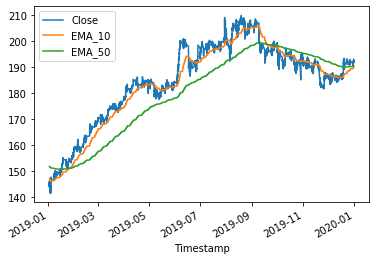

In [38]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'EMA_10', 'EMA_50'])

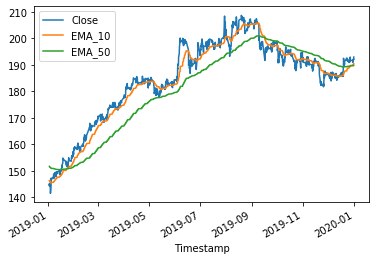

In [39]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'EMA_10', 'EMA_50'])

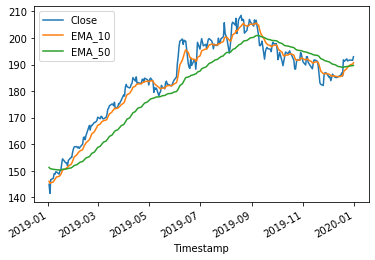

In [40]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'EMA_10', 'EMA_50'])

### Relative Strength Index

In [41]:
full['RSI'] = ta.momentum.rsi(full['Close'], n=14*60*8, fillna=False)

hour['RSI'] = ta.momentum.rsi(hour['Close'], n=14*8, fillna=False)

day['RSI'] = ta.momentum.rsi(day['Close'], n=14, fillna=False)

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [42]:
#full.head(20)
#hour.head(20)
#day.head(20)

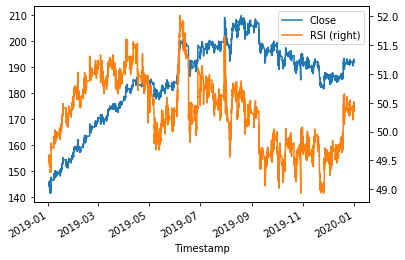

In [43]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'RSI'], secondary_y=['RSI'])

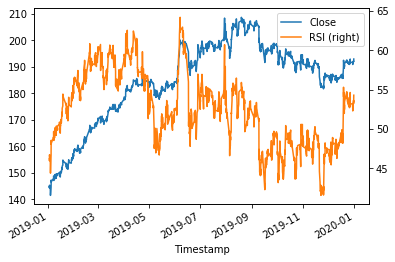

In [44]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'RSI'], secondary_y=['RSI'])

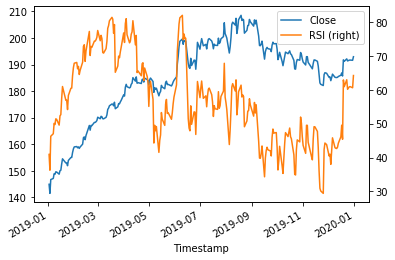

In [45]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'RSI'], secondary_y=['RSI'])

### Rate of Change

In [46]:
full['ROC'] = ta.momentum.roc(full['Close'], n=12*60*8, fillna=False)

hour['ROC'] = ta.momentum.roc(hour['Close'], n=12*8, fillna=False)

day['ROC'] = ta.momentum.roc(day['Close'], n=12, fillna=False)

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [47]:
#full.head(20)
#hour.head(20)
#day.head(20)

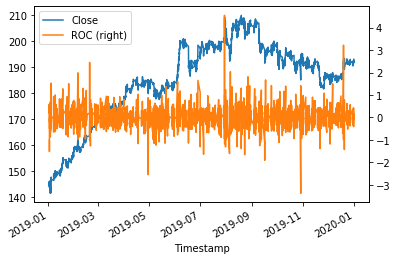

In [48]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'ROC'], secondary_y=['ROC'])

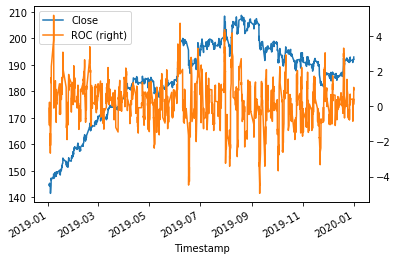

In [49]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'ROC'], secondary_y=['ROC'])

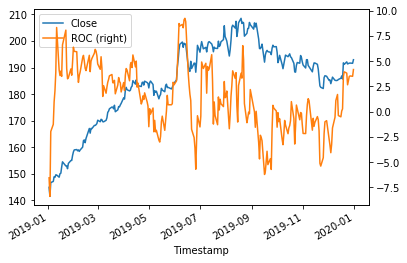

In [50]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'ROC'], secondary_y=['ROC'])

### MACD

In [51]:
macd_full = ta.trend.MACD(full['Close'],
                     n_slow = 50*60*8, 
                     n_fast = 10*60*8,
                     n_sign = 9, 
                     fillna = False)

full['MACD_Line'] = macd_full.macd()
full['MACD_Diff'] = macd_full.macd_diff()
full['MACD_Sig'] = macd_full.macd_signal()
#full.head(50)

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

In [52]:
macd_hour = ta.trend.MACD(hour['Close'],
                     n_slow = 50*8, 
                     n_fast = 10*8,
                     n_sign = 9, 
                     fillna = False)

hour['MACD_Line'] = macd_hour.macd()
hour['MACD_Diff'] = macd_hour.macd_diff()
hour['MACD_Sig'] = macd_hour.macd_signal()
#hour.head(50)

In [53]:
macd_day = ta.trend.MACD(day['Close'],
                     n_slow = 50, 
                     n_fast = 10,
                     n_sign = 9, 
                     fillna = False)

day['MACD_Line'] = macd_day.macd()
day['MACD_Diff'] = macd_day.macd_diff()
day['MACD_Sig'] = macd_day.macd_signal()
#day.head(50)

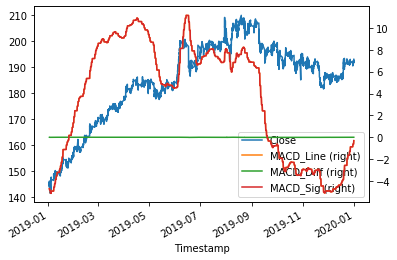

In [54]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'MACD_Line', 'MACD_Diff', 'MACD_Sig'],
                                             secondary_y=['MACD_Line', 'MACD_Diff', 'MACD_Sig'])

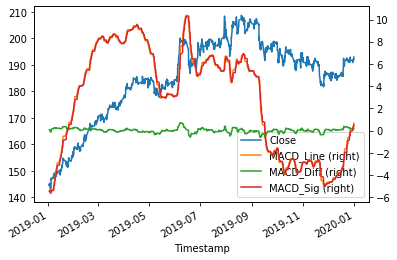

In [55]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'MACD_Line', 'MACD_Diff', 'MACD_Sig'],
                                             secondary_y=['MACD_Line', 'MACD_Diff', 'MACD_Sig'])

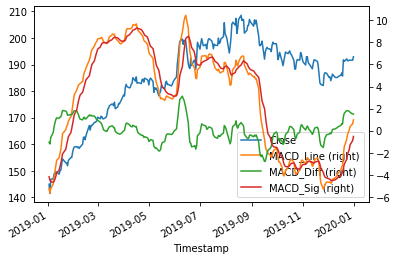

In [56]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['Close', 'MACD_Line', 'MACD_Diff', 'MACD_Sig'],
                                             secondary_y=['MACD_Line', 'MACD_Diff', 'MACD_Sig'])

### Williams Oscillator

In [57]:
wo_full = ta.momentum.UltimateOscillator(full['High'],
                                    full['Low'],
                                    full['Close'],
                                    s = 7, 
                                    m = 14, 
                                    len = 28, 
                                    ws = 4.0, 
                                    wm = 2.0,
                                    wl = 1.0, 
                                    fillna = False)

full['WO'] = wo_full.uo()

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [58]:
wo_hour = ta.momentum.UltimateOscillator(hour['High'],
                                    hour['Low'],
                                    hour['Close'],
                                    s = 7, 
                                    m = 14, 
                                    len = 28, 
                                    ws = 4.0, 
                                    wm = 2.0,
                                    wl = 1.0, 
                                    fillna = False)

hour['WO'] = wo_hour.uo()

In [59]:
wo_day = ta.momentum.UltimateOscillator(day['High'],
                                    day['Low'],
                                    day['Close'],
                                    s = 7, 
                                    m = 14, 
                                    len = 28, 
                                    ws = 4.0, 
                                    wm = 2.0,
                                    wl = 1.0, 
                                    fillna = False)

day['WO'] = wo_day.uo()

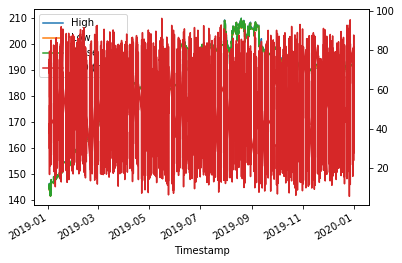

In [60]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'WO'], secondary_y=['WO'])

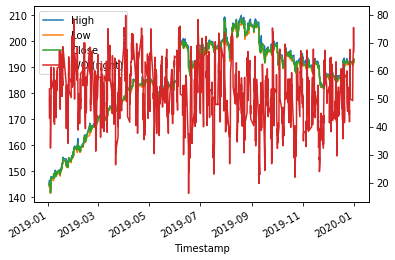

In [61]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'WO'], secondary_y=['WO'])

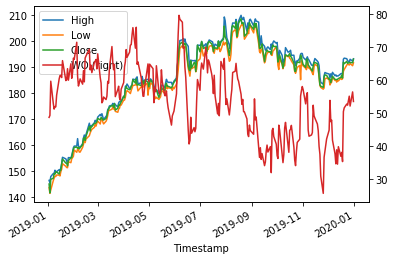

In [62]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'WO'], secondary_y=['WO'])

### Average True Range

In [63]:
atr_full = ta.volatility.AverageTrueRange(full['High'], 
                                     full['Low'], 
                                     full['Close'], 
                                     n = 14*60*8, 
                                     fillna = False)

full['ATR'] = atr_full.average_true_range()

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [64]:
atr_hour = ta.volatility.AverageTrueRange(hour['High'], 
                                     hour['Low'], 
                                     hour['Close'], 
                                     n = 14*8, 
                                     fillna = False)

hour['ATR'] = atr_hour.average_true_range()

In [65]:
atr_day = ta.volatility.AverageTrueRange(day['High'], 
                                     day['Low'], 
                                     day['Close'], 
                                     n = 14, 
                                     fillna = False)

day['ATR'] = atr_day.average_true_range()

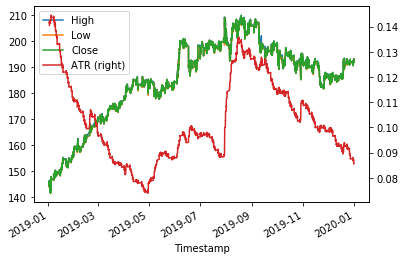

In [66]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'ATR'], secondary_y=['ATR'])

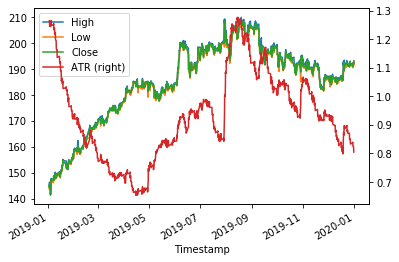

In [67]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'ATR'], secondary_y=['ATR'])

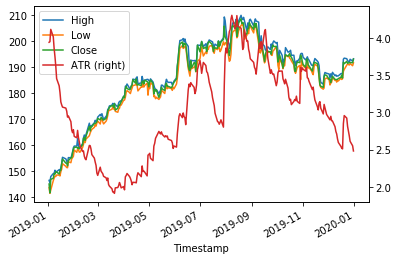

In [68]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'ATR'], secondary_y=['ATR'])

In [69]:
#Add a volume TA. There is currently none taking in volume

### ADI

In [70]:
adi_full = ta.volume.AccDistIndexIndicator(full['High'], 
                                     full['Low'], 
                                     full['Close'], 
                                     full['Volume'],
                                     fillna = False)

full['ADI'] = adi_full.acc_dist_index()

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [71]:
adi_hour = ta.volume.AccDistIndexIndicator(hour['High'], 
                                     hour['Low'], 
                                     hour['Close'], 
                                     hour['Volume'],
                                     fillna = False)

hour['ADI'] = adi_hour.acc_dist_index()

In [72]:
adi_day = ta.volume.AccDistIndexIndicator(day['High'], 
                                     day['Low'], 
                                     day['Close'], 
                                     day['Volume'],
                                     fillna = False)

day['ADI'] = adi_day.acc_dist_index()

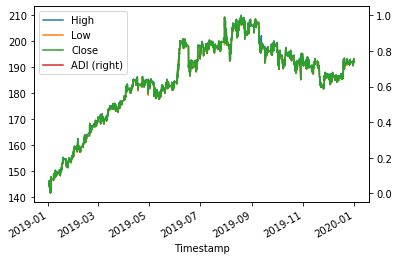

In [73]:
if True:
    full[full.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'ADI'], secondary_y=['ADI'])

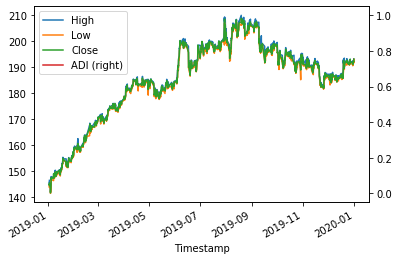

In [74]:
if True:
    hour[hour.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'ADI'], secondary_y=['ADI'])

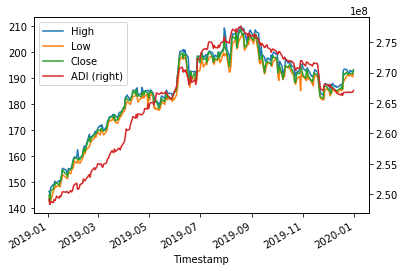

In [75]:
if True:
    day[day.Timestamp > '2019-01-01'].plot(x='Timestamp', y=['High', 'Low','Close', 'ADI'], secondary_y=['ADI'])

### Check everything looks right

In [76]:
print('Shape of Minute Resolution:',full.shape)
print('Shape of Hour Resolution:',hour.shape)
print('Shape of Day Resolution:',day.shape)

Shape of Minute Resolution: (1953810, 18)
Shape of Hour Resolution: (40110, 18)
Shape of Day Resolution: (5031, 18)


In [77]:
print(full.columns)
print(hour.columns)
print(day.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10',
       'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'ROC', 'MACD_Line', 'MACD_Diff',
       'MACD_Sig', 'WO', 'ATR', 'ADI'],
      dtype='object')
Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10',
       'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'ROC', 'MACD_Line', 'MACD_Diff',
       'MACD_Sig', 'WO', 'ATR', 'ADI'],
      dtype='object')
Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'SMA_10',
       'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'ROC', 'MACD_Line', 'MACD_Diff',
       'MACD_Sig', 'WO', 'ATR', 'ADI'],
      dtype='object')


In [78]:
#Check everything looks right

#full.tail(50)
#hour.tail(50)
#day.tail(50)

In [79]:
#full.describe()
#hour.describe()
#day.describe()

## PCA

In [80]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [81]:
X = day.drop(['Close', 'Timestamp'], axis=1)
y = day['Close']

In [82]:
#X['Timestamp'] = X['Timestamp'].astype(np.int64)
#X.head(3).dropna(inplace=True)

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [84]:
X_train.dropna(inplace=True)
X_test.dropna(inplace=True)
y_train.dropna(inplace=True)
y_test.dropna(inplace=True)

/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jacobscottanthony/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [86]:
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [87]:
explained_variance = pca.explained_variance_ratio_

In [88]:
explained_variance

array([8.00108509e-01, 8.01322959e-02, 4.99147705e-02, 2.70251578e-02,
       1.44706241e-02, 1.30363974e-02, 7.69436562e-03, 5.38586830e-03,
       1.99906860e-03, 1.16949895e-04, 7.41918071e-05, 2.87015550e-05,
       1.04684368e-05, 2.63095077e-06, 6.41289265e-33, 2.19005348e-33])

In [89]:
labels = day.drop(['Close', 'Timestamp'], axis=1).columns
labels

Index(['Open', 'High', 'Low', 'Volume', 'SMA_10', 'SMA_50', 'EMA_10', 'EMA_50',
       'RSI', 'ROC', 'MACD_Line', 'MACD_Diff', 'MACD_Sig', 'WO', 'ATR', 'ADI'],
      dtype='object')

In [90]:
series = pd.Series(explained_variance)

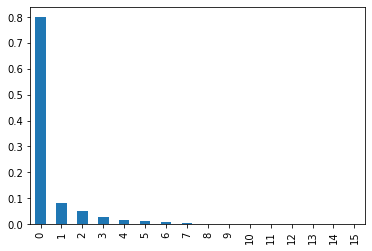

In [91]:
series.plot(kind='bar')

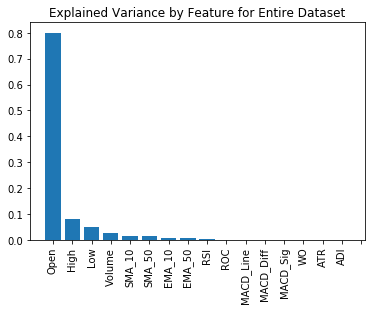

In [92]:
ax = plt.bar(labels, series)
plt.xticks(range(0, len(series)+1), labels, rotation=90)
plt.title('Explained Variance by Feature for Entire Dataset')
plt.show()

## Export the cleaned data to a csv

In [93]:
if False:
    full.to_csv('Clean Data/ECL_Clean_Minute.csv')

In [94]:
if True:
    hour.to_csv('Clean Data/ECL_Clean_Hour.csv')

In [95]:
if True:
    day.to_csv('Clean Data/ECL_Clean_Day.csv')